In [1]:
# # Simple MNIST Digit Generator with Flux.jl
#
# This tutorial demonstrates how to train a simple neural network to generate MNIST digits conditioned on class labels. We use Flux.jl, a powerful machine learning library in Julia.

# ## 1. Setup and Data Loading

using Pkg
# Uncomment if not already installed:
# Pkg.add(["Flux", "MLDatasets", "Plots"])

using Flux, MLDatasets, Plots, Statistics

# Set plotting backend
Plots.gr()

# Create directory for outputs
mkpath("mnist")

# Load the MNIST training set (first 1000 samples)
train_data = MLDatasets.MNIST(split = :train)
train_x = reshape(train_data.features[:, :, 1:1000], 28 * 28, :) ./ 255f0
train_y = Flux.onehotbatch(train_data.targets[1:1000], 0:9)
data = Flux.DataLoader((train_x, train_y), batchsize = 1, shuffle = true)

println("Data loaded and preprocessed.")



Data loaded and preprocessed.


In [2]:
# ## 2. Define Generator Model

noise_dim = 10
label_dim = 10

# Define a simple feed-forward generator network
# generator = Chain(
#     Dense(noise_dim + label_dim => 256, relu),
#     Dense(256 => 512, sigmoid),
#     Dense(512 => 784, sigmoid)
# )

# using Flux: BatchNorm
# generator = Chain(
#     Dense(noise_dim + label_dim => 256), BatchNorm(256, relu),
#     Dense(256 => 512), BatchNorm(512, relu),
#     Dense(512 => 1024), BatchNorm(1024, relu),
#     Dense(1024 => 784, sigmoid)
# )
using Flux: Dropout

generator = Chain(
    Dense(noise_dim + label_dim => 256), relu, Dropout(0.3),
    Dense(256 => 512), relu, Dropout(0.3),
    Dense(512 => 1024), relu, Dropout(0.3),
    Dense(1024 => 784, sigmoid)
)
# Binary cross-entropy loss function
function generator_loss(model, x, y)
    z = randn(Float32, noise_dim, size(x, 2))
    zy = vcat(z, y)
    x̂ = model(zy)
    return Flux.binarycrossentropy(x̂, x, agg = mean)
end

println("Generator model defined.")



Generator model defined.


In [3]:
# ## 3. Train the Generator

opt = Flux.ADAM(0.001)
state = Flux.setup(opt, generator)

# Pre-training: small number of epochs
for epoch in 1:2
    epoch_loss = 0.0
    for (x, y) in data
        Flux.train!(generator_loss, generator, [(x, y)], state)
        epoch_loss += generator_loss(generator, x, y)
    end
    avg_loss = epoch_loss / length(data)
    println("Pre-Epoch $epoch: Loss = $(round(avg_loss, digits=4))")
end



Pre-Epoch 1: Loss = 0.0113
Pre-Epoch 2: Loss = 0.0042


Ready to generate images.


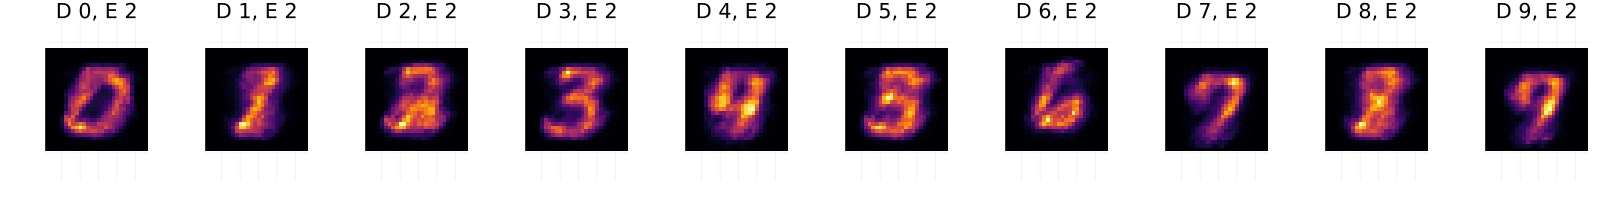

In [23]:
# ## 4. Image Generation Function

function generate_image(model, digit::Int; samples = 4, epoch = 0)
    y = Flux.onehot(digit, 0:9)
    plot_list = []
    for _ in 1:samples
        z = randn(Float32, noise_dim)
        zy = vcat(z, y)
        img = reshape(model(zy), 28, 28)
        p = heatmap(img, color = :grays, axis = false, title = "Digit $digit",
                    aspect_ratio = :equal, size = (200, 200), colorbar = false)
        push!(plot_list, p)
    end
    gen_plot = plot(plot_list..., layout = (1, samples), size = (800, 200))
    filename = joinpath("mnist", "generated_digit_$(digit)_epoch_$(epoch).png")
    savefig(gen_plot, filename)
    display(gen_plot)
end

function generate_images(model; epoch = 0)
    plot_list = []
    
    for digit in 0:9
        y = Flux.onehot(digit, 0:9)

        z = randn(Float32, noise_dim)
        zy = vcat(z, y)
        img = reshape(model(zy), 28, 28)'  # Transpose with '
        img = reverse(img, dims=1)
        p = heatmap(img,  axis = false, title = "D $digit, E $epoch", aspect_ratio = :equal, size = (200, 200), colorbar = false)
        push!(plot_list, p)
    end
    gen_plot = plot(plot_list..., layout = (1, 10), size = (1600, 200))
    # filename = joinpath("mnist", "generated_digit_$(digit)_epoch_$(epoch).png")
    # savefig(gen_plot, filename)
    display(gen_plot)
end
println("Ready to generate images.")

generate_images(generator, epoch=2)

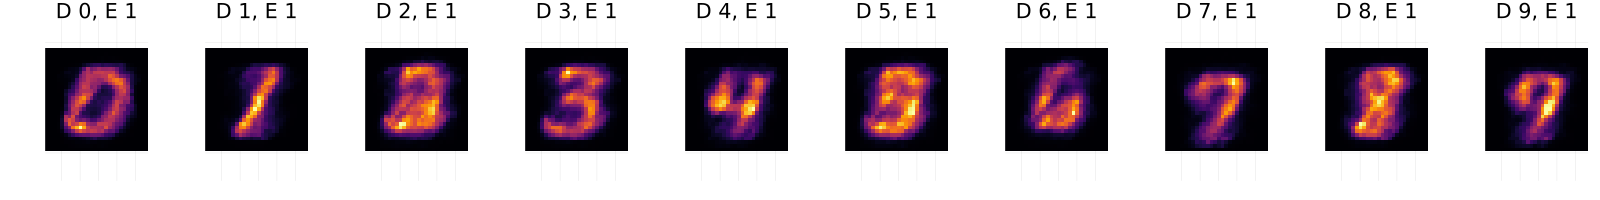

Epoch 1: Loss = 0.0038


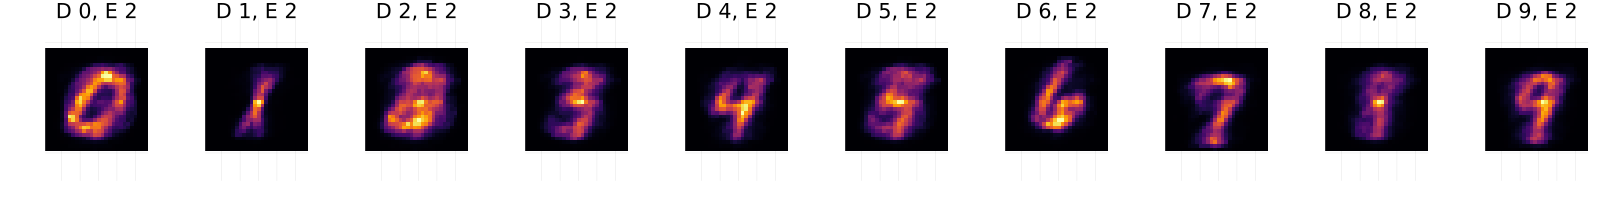

Epoch 2: Loss = 0.0038


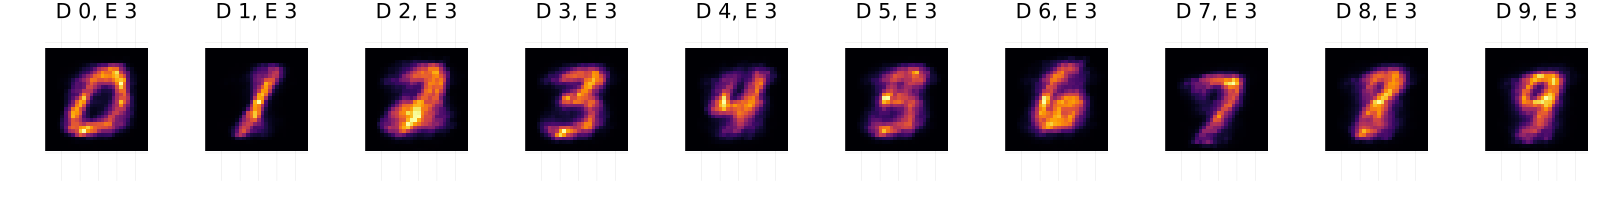

Epoch 3: Loss = 0.0038


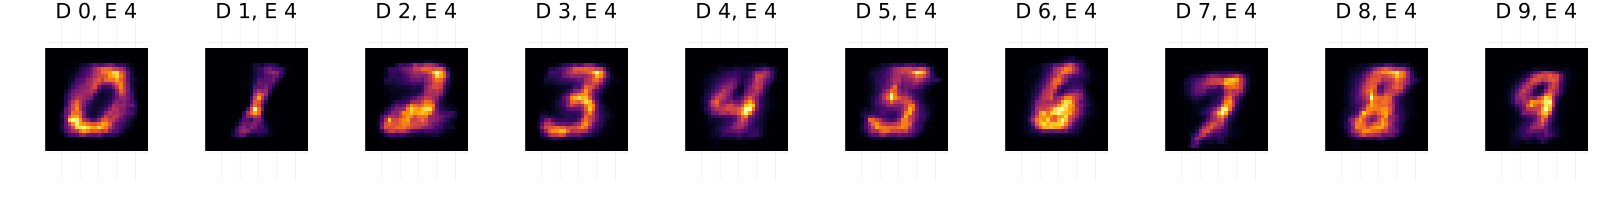

Epoch 4: Loss = 0.0038


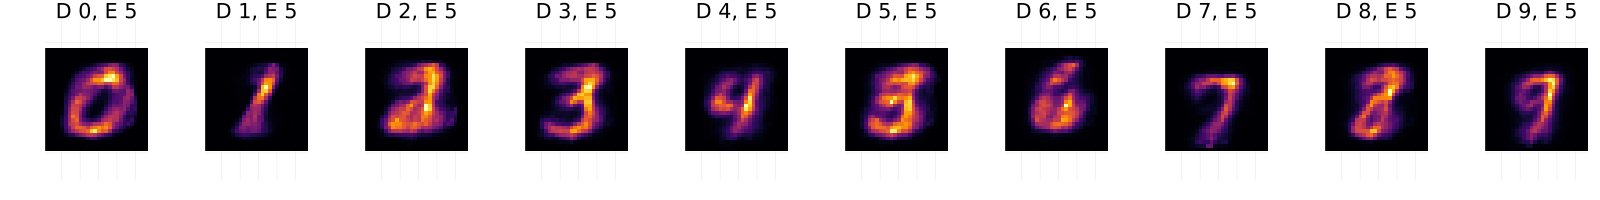

Epoch 5: Loss = 0.0038


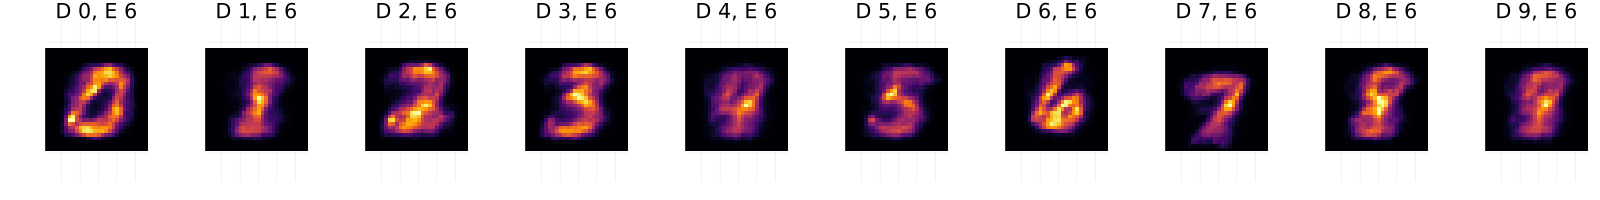

In [ ]:
# ## 5. Full Training Loop with Learning Rate Decay and Image Logging

# learning_rate0 = 0.01
losses = Float32[]

for epoch in 1:10
    epoch_loss = 0.0
    # learning_rate = learning_rate0 * exp(-0.2 * (epoch - 1))
    # Optimisers.adjust!(state, learning_rate)
    
    # Save sample images
    if epoch % 1 == 0
        generate_images(generator, epoch = epoch)
    end

    for (x, y) in data
        Flux.train!(generator_loss, generator, [(x, y)], state)
        epoch_loss += generator_loss(generator, x, y)
    end

    avg_loss = epoch_loss / length(data)
    push!(losses, avg_loss)
    println("Epoch $epoch: Loss = $(round(avg_loss, digits = 4))")


end



In [ ]:
# ## 6. Plot Training Loss

plot(losses, title = "Generator Training Loss", xlabel = "Epoch", ylabel = "Loss")
savefig("mnist/loss_curve.png")
display(plot(losses))

println("Training complete.")